In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import os
from datetime import datetime

c:\Users\user\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\user\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


- cluster cell lines by its lineage
- used "IC50_AUC_with_Metadata.csv" instead of "IC50_AUC_merged.csv"
- try clustering by lineage_1 first, and later we can try other lineages

In [2]:
# 암세포주의 lineage별로 그룹화해서 따로 데이터프레임을 만들고 각 데이터프레임과 다른 오믹스 데이터 합치기 
# 아님 걍 다 합친담에 그룹화해서 분리하면 안됨?

In [3]:
data_directory = 'data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_with_Metadata.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]

In [4]:
# Read and modify batch_corrected_expression
batch_corrected_expression = pd.read_csv(f'{data_directory}{file_names[0]}')
batch_corrected_expression = batch_corrected_expression.rename(columns={batch_corrected_expression.columns[0]: "CellLineID"})
batch_corrected_expression.columns = ['CellLineID'] + [f"1_{col}" for col in batch_corrected_expression.columns[1:]]

# Read and modify damaging_mutations
damaging_mutations = pd.read_csv(f'{data_directory}{file_names[1]}')
damaging_mutations = damaging_mutations.rename(columns={damaging_mutations.columns[0]: "CellLineID"})
damaging_mutations.columns = ['CellLineID'] + [f"2_{col}" for col in damaging_mutations.columns[1:]]

# Read and modify harmonized_RPPA
harmonized_RPPA = pd.read_csv(f'{data_directory}{file_names[2]}')
harmonized_RPPA = harmonized_RPPA.rename(columns={harmonized_RPPA.columns[0]: "CellLineID"})
harmonized_RPPA.columns = ['CellLineID'] + [f"3_{col}" for col in harmonized_RPPA.columns[1:]]

# Read and modify hotspot_mutations
hotspot_mutations = pd.read_csv(f'{data_directory}{file_names[3]}')
hotspot_mutations = hotspot_mutations.rename(columns={hotspot_mutations.columns[0]: "CellLineID"})
hotspot_mutations.columns = ['CellLineID'] + [f"4_{col}" for col in hotspot_mutations.columns[1:]]

IC50_AUC = pd.read_csv(f'{data_directory}{file_names[4]}')
IC50_AUC = IC50_AUC.rename(columns={IC50_AUC.columns[0]: "CellLineID"})

# Read and modify metabolomics
metabolomics = pd.read_csv(f'{data_directory}{file_names[5]}')
metabolomics = metabolomics.rename(columns={metabolomics.columns[0]: "CellLineID"})
metabolomics.columns = ['CellLineID'] + [f"5_{col}" for col in metabolomics.columns[1:]]

# Read and modify miRNA_expression
miRNA_expression = pd.read_csv(f'{data_directory}{file_names[6]}')
miRNA_expression = miRNA_expression.rename(columns={miRNA_expression.columns[0]: "CellLineID"})
miRNA_expression.columns = ['CellLineID'] + [f"6_{col}" for col in miRNA_expression.columns[1:]]

# Read and modify absolute_copy_number
absolute_copy_number = pd.read_csv(f'{data_directory}{file_names[7]}')
absolute_copy_number = absolute_copy_number.rename(columns={absolute_copy_number.columns[0]: "CellLineID"})
#absolute_copy_number = absolute_copy_number.drop(columns=["cell_line_display_name", "lineage_1", "lineage_2", "lineage_3", "lineage_6", "lineage_4"])
absolute_copy_number.columns = ['CellLineID'] + [f"7_{col}" for col in absolute_copy_number.columns[1:]]


In [5]:
IC50_AUC = IC50_AUC.drop(columns=["cell_line_display_name",	"lineage_2", "lineage_3", "lineage_6", "lineage_4"])

In [6]:
# IC50, AUC, SMILES combine
smiles = pd.read_csv("./data/drugID_name_pubchem_smiles.csv")
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)


In [7]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID", "lineage_1"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)

pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'lineage_1', 'value', 'Metric','DrugNumber']]

In [8]:
new_melted

,CellLineID,lineage_1,value,Metric,DrugNumber
0,ACH-000001,Ovary/Fallopian Tube,0.967187,AUC,1003
1,ACH-000002,Myeloid,0.711866,AUC,1003
2,ACH-000004,Myeloid,0.742350,AUC,1003
3,ACH-000006,Myeloid,0.752250,AUC,1003
4,ACH-000007,Bowel,0.845466,AUC,1003
...,...,...,...,...,...
258787,ACH-002312,Biliary Tract,NaN,IC50,2172
258788,ACH-002313,Lymphoid,NaN,IC50,2172
258789,ACH-002314,Myeloid,NaN,IC50,2172
258790,ACH-002316,Myeloid,NaN,IC50,2172


In [9]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber", "lineage_1"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None
final_IC50_AUC

AUC     IC50
CellLineID DrugNumber lineage_1                              
ACH-000001 1003       Ovary/Fallopian Tube  0.967187      NaN
           1004       Ovary/Fallopian Tube  0.666062      NaN
           1005       Ovary/Fallopian Tube  0.977907      NaN
           1007       Ovary/Fallopian Tube  0.922989      NaN
           1010       Ovary/Fallopian Tube  0.957586      NaN
...                                              ...      ...
ACH-002317 2096       Lymphoid              0.946713      NaN
           2107       Lymphoid              0.926422      NaN
           2109       Lymphoid              0.916274  3.25832
           2110       Lymphoid              0.906540      NaN
           2170       Lymphoid              0.996681      NaN

[98146 rows x 2 columns]

In [10]:
final_IC50_AUC.to_csv("temp.csv")
IC50_AUC_final = pd.read_csv("temp.csv")
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')
ic50_data = df_merged[['CellLineID', 'DrugNumber', 'lineage_1', 'smiles', 'CLS', 'IC50']].copy()
ic50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = ic50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'lineage_1', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
IC50_AUC_CLS = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

IC50_AUC_CLS = IC50_AUC_CLS.drop(columns=["DrugNumber", "smiles"])

C:\Users\user\AppData\Local\Temp\ipykernel_7348\743409598.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


In [11]:
IC50_AUC_CLS

,CellLineID,lineage_1,CLS,IC50,AUC
0,ACH-000001,Ovary/Fallopian Tube,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",NaN,0.967187
1,ACH-000001,Ovary/Fallopian Tube,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",NaN,0.666062
2,ACH-000001,Ovary/Fallopian Tube,"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",NaN,0.977907
3,ACH-000001,Ovary/Fallopian Tube,"[0.5116886, 0.7362517, -1.3978803, -0.69533825...",NaN,0.922989
4,ACH-000001,Ovary/Fallopian Tube,"[-0.73378813, 0.74604344, -1.19528, 1.1188792,...",NaN,0.957586
...,...,...,...,...,...
117299,ACH-002317,Lymphoid,"[0.32438743, -0.20456038, -0.47426504, 0.15297...",NaN,0.926422
117300,ACH-002317,Lymphoid,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",3.25832,NaN
117301,ACH-002317,Lymphoid,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",NaN,0.916274
117302,ACH-002317,Lymphoid,"[-0.07692237, -0.47833273, -0.6763192, -0.5061...",NaN,0.906540


In [12]:
# apply scaling method which were used to train individual models

# expression: PCA
expression_cnv = batch_corrected_expression.iloc[:, 1:]
pca_expression = PCA(n_components=500)
expression_pca = pca_expression.fit_transform(expression_cnv)
expression_pca_df = pd.DataFrame(expression_pca)
expression_pca_df.insert(0, "CellLineID", batch_corrected_expression["CellLineID"].values)
expression_pca_df.columns = ['CellLineID'] + [f"1_{col}" for col in expression_pca_df.columns[1:]]
expression_pca_df

,CellLineID,1_0,1_1,1_2,1_3,1_4,1_5,1_6,1_7,1_8,...,1_490,1_491,1_492,1_493,1_494,1_495,1_496,1_497,1_498,1_499
0,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,-0.332627,3.851038,-0.787419,-2.266812,0.487926,2.129702,-2.158321,-0.144185,3.377951,4.534081
1,ACH-000860,-13.205043,35.412796,18.626327,-18.780661,-3.658211,-18.184392,-9.531211,-6.630401,0.281756,...,-2.987305,5.245047,-3.531820,-1.906074,0.622698,1.128630,-0.415045,0.454741,-3.410475,-4.541591
2,ACH-000439,105.578540,-7.727870,-54.957863,12.811952,-0.432278,10.199582,8.024432,48.359902,-5.190777,...,1.261462,1.605248,-1.488805,3.230083,4.386783,0.838330,1.487367,4.557777,0.113763,-1.685800
3,ACH-000318,-7.327347,53.451898,-7.430361,19.708346,-17.924429,-16.075850,-29.364873,-9.784038,-11.851439,...,0.829418,-2.057993,-0.775093,0.488841,-1.823936,1.321619,-1.261592,4.017776,3.128991,-0.464166
4,ACH-001142,-68.076659,-48.781471,-41.877034,-14.293056,-13.285048,10.213185,13.815636,-1.810762,-3.815925,...,0.217239,-0.271465,-0.997210,0.868042,1.911490,0.205764,-0.160945,-1.583375,-2.004294,-0.513732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1668,ACH-001843,-17.993345,-23.106219,-11.477149,12.734862,10.910127,-2.627428,7.090688,10.285014,7.435539,...,1.476141,-2.524353,0.994377,2.126448,3.033392,1.857084,1.730885,3.424471,-2.893584,1.821551
1669,ACH-002074,13.293219,-34.315645,124.754849,-4.390610,-27.125356,37.669803,-2.080660,-38.162244,9.140773,...,-2.349410,0.048023,-4.675738,3.211581,0.504608,-2.383434,-3.406533,-5.081783,-1.850355,-1.996575
1670,ACH-001164,7.325350,-23.149983,-20.506041,41.769200,-14.242126,21.603492,10.547421,29.343744,2.192337,...,0.125124,2.890942,1.787981,-0.437198,-1.395469,0.897237,1.856976,3.852172,0.015728,-3.072462
1671,ACH-003180,-53.328758,-50.682140,-29.751308,-13.790538,-17.731040,16.326983,16.623389,-8.590972,-25.676557,...,1.992406,1.556845,3.843815,-1.866201,1.328655,2.809770,-3.424798,-3.757006,-0.070373,1.484266


In [13]:
# damaging mutation: Variance threshold + rubust scaling
dmg_mut = damaging_mutations.drop(columns="CellLineID")
selector_mut = VarianceThreshold(threshold=0.01)
dmg_mut_reduced = selector_mut.fit_transform(dmg_mut)
selected_columns_mut = dmg_mut.columns[selector_mut.get_support()]
scaler_mut = RobustScaler()
dmg_mut_reduced = scaler_mut.fit_transform(dmg_mut_reduced) 
dmg_mut_reduced_df = pd.DataFrame(dmg_mut_reduced, columns=selected_columns_mut)
dmg_mut_reduced_df = pd.concat([damaging_mutations["CellLineID"], dmg_mut_reduced_df], axis=1)
dmg_mut_reduced_df

,CellLineID,2_A2ML1,2_ABCA10,2_ABCA12,2_ABCA13,2_ABCA2,2_ABCA4,2_ABCA5,2_ABCA6,2_ABCA8,...,2_ZNF711,2_ZNF729,2_ZNF750,2_ZNF804B,2_ZNF831,2_ZNF90,2_ZNF99,2_ZRANB3,2_ZSWIM6,2_ZZEF1
0,ACH-000001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACH-000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ACH-000004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ACH-000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ACH-000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1925,ACH-003474,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1926,ACH-003475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1927,ACH-003476,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# protein: standard scaler
prot = harmonized_RPPA.drop(columns="CellLineID")
scaler_protein = StandardScaler()
protein_scaled = scaler_protein.fit_transform(prot)
protein_scaled_df = pd.DataFrame(protein_scaled)
protein_scaled_df.insert(0, "CellLineID", harmonized_RPPA["CellLineID"].values)
protein_scaled_df.columns = ['CellLineID'] + [f"3_{col}" for col in protein_scaled_df.columns[1:]]
protein_scaled_df

,CellLineID,3_0,3_1,3_2,3_3,3_4,3_5,3_6,3_7,3_8,...,3_134,3_135,3_136,3_137,3_138,3_139,3_140,3_141,3_142,3_143
0,ACH-000698,-0.612917,0.223323,0.606426,0.721333,0.110235,0.179933,-0.114938,-0.940047,-0.957034,...,-1.062067,2.484835,-0.517883,-1.016179,1.475021,-0.654903,-0.819080,-0.021027,-0.314445,-0.504282
1,ACH-000489,1.649916,-1.009740,-0.200529,0.038992,1.579026,-0.893064,-0.443334,-0.060601,0.154512,...,1.980290,6.054042,0.067953,0.662172,1.235912,-0.275541,0.767357,0.444319,-0.646511,-0.023882
2,ACH-000431,0.039605,0.282172,-0.324024,0.340225,-0.044571,0.972972,-0.527327,-0.154960,0.964029,...,-1.185110,-0.428942,-0.700518,2.254630,-0.697849,-0.651034,-0.850240,0.602303,-0.906461,1.634607
3,ACH-000707,0.485446,-0.428368,-0.400411,-0.041245,-1.136608,0.183832,-1.495605,0.244413,-0.756761,...,-1.331765,-0.183950,-0.809336,-0.026228,0.948358,2.253929,-3.090354,-1.461826,2.234051,0.081316
4,ACH-000509,-1.414293,-0.394963,-0.423156,-0.781748,-0.612832,-0.349126,0.679537,-1.288470,0.694292,...,0.936852,-0.168559,-0.738633,-0.710741,-0.760559,2.050669,-0.334478,-0.368402,-0.982283,1.228356
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,ACH-000428,0.110377,0.391061,0.137401,-0.395569,-0.221911,1.067014,0.336480,-0.960471,0.388553,...,-0.300115,0.262923,0.710310,0.230650,-0.365990,-0.371611,0.641735,-0.390669,0.906651,-0.327067
895,ACH-000655,-0.269672,0.251754,-0.863469,-0.349136,-1.260717,-0.185840,-0.195436,-0.649806,-0.837895,...,-1.029560,-0.317276,-0.255798,-0.686808,-0.209949,-0.458913,-0.094344,-1.043973,-1.472114,-0.579963
896,ACH-000273,-1.326400,2.067889,-0.875423,0.569805,0.003275,-0.113267,0.732226,-0.177328,1.495660,...,-0.670747,-1.012161,-0.585764,-0.377737,-0.285001,-0.276757,-0.173452,-1.107292,0.207267,0.561858
897,ACH-000504,-0.783560,0.911902,-0.418151,-0.612986,-0.056590,-0.310806,0.402894,-0.442600,0.504737,...,-1.541053,-0.800185,-0.505402,0.393043,-0.357944,-0.497675,0.491758,-0.902171,-1.446228,-0.568729


In [15]:
# hotspot mutation: standard scaler
hot_mut = hotspot_mutations.drop(columns="CellLineID")
scaler_hotspot = StandardScaler()
hotspot_scaled = scaler_hotspot.fit_transform(hot_mut)
hotspot_scaled_df = pd.DataFrame(hotspot_scaled)
hotspot_scaled_df.insert(0, "CellLineID", hotspot_mutations["CellLineID"].values)
hotspot_scaled_df.columns = ['CellLineID'] + [f"4_{col}" for col in hotspot_scaled_df.columns[1:]]
hotspot_scaled_df

,CellLineID,4_0,4_1,4_2,4_3,4_4,4_5,4_6,4_7,4_8,...,4_529,4_530,4_531,4_532,4_533,4_534,4_535,4_536,4_537,4_538
0,ACH-000001,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1,ACH-000002,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
2,ACH-000004,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
3,ACH-000005,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
4,ACH-000006,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1924,ACH-003473,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1925,ACH-003474,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1926,ACH-003475,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774
1927,ACH-003476,-0.032216,-0.022774,-0.022774,-0.022774,-0.022774,-0.030561,-0.032216,-0.022774,-0.032216,...,-0.022774,-0.050978,-0.032216,-0.022774,-0.032216,-0.039467,-0.022774,-0.032216,-0.022774,-0.022774


In [16]:
# metabolomics: standard scaler
meta = metabolomics.drop(columns="CellLineID")
scaler_metabolomics = StandardScaler()
metabolomics_scaled = scaler_metabolomics.fit_transform(meta)
metabolomics_scaled_df = pd.DataFrame(metabolomics_scaled)
metabolomics_scaled_df.insert(0, "CellLineID", metabolomics["CellLineID"].values)
metabolomics_scaled_df.columns = ['CellLineID'] + [f"5_{col}" for col in metabolomics_scaled_df.columns[1:]]
metabolomics_scaled_df

,CellLineID,5_0,5_1,5_2,5_3,5_4,5_5,5_6,5_7,5_8,...,5_215,5_216,5_217,5_218,5_219,5_220,5_221,5_222,5_223,5_224
0,ACH-000698,0.557284,0.515189,-0.054878,0.135187,-1.043681,-0.129531,0.414312,-0.638396,-0.129797,...,0.513798,0.426691,0.353608,0.708122,1.060755,0.750534,-0.028667,0.681854,0.339773,0.172341
1,ACH-000489,-1.153386,-0.455615,-1.561702,0.352185,-0.099291,-0.252544,-0.036573,-0.363507,-0.471001,...,1.023767,1.569556,1.036571,0.879770,1.033590,1.087359,0.433064,2.113894,1.574201,0.873145
2,ACH-000431,-0.165981,-0.936554,-0.737158,-0.318869,-0.548701,-0.109933,-0.005529,-0.103380,-0.509048,...,0.149783,0.000650,-0.248786,-0.001200,0.518728,-0.264772,-0.578523,-0.130029,-0.230330,-0.782058
3,ACH-000707,-0.537852,0.720730,0.590426,-1.228664,-0.212848,0.672876,1.097971,0.297578,0.747467,...,1.790577,0.381808,0.808239,0.689492,0.454086,0.341955,-0.245347,0.908357,-0.239624,0.638919
4,ACH-000509,-1.462500,-1.268864,1.120189,0.882626,-2.099762,-0.049797,1.287728,-0.950836,-0.238966,...,0.776029,1.899423,1.746608,1.610213,1.932546,1.219787,1.706747,1.530576,1.395632,1.867989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,ACH-000655,0.125581,0.490805,1.064821,0.467987,0.148612,-0.509327,0.434753,2.158001,-0.717929,...,-0.979465,-0.554915,-0.858667,-0.838440,-1.267921,-1.512691,-0.924243,-0.767200,-1.760266,-0.776712
923,ACH-000273,0.060382,0.694197,-1.154972,0.568667,-0.299668,-0.864138,1.470717,0.497303,-0.673935,...,-0.506716,-0.674703,-0.527957,-1.083407,-1.467146,-1.595997,-1.068780,-0.788050,-1.343282,-0.881662
924,ACH-000504,0.093852,0.190556,-0.585055,0.000092,0.334694,-1.480546,0.305665,1.356817,-0.959219,...,-0.814866,-1.437779,-0.743024,-0.989967,-1.340031,-1.103159,-0.890545,-1.521454,-1.565363,-1.533381
925,ACH-000825,0.076940,0.383840,0.711219,-0.115915,0.690186,-0.086400,0.299768,1.142896,-0.344986,...,0.169536,0.691391,0.728826,0.445061,-0.090201,-0.217227,0.107072,0.873816,0.321537,0.919807


In [17]:
# miRNA: standard scaler
rna = miRNA_expression.drop(columns="CellLineID")
scaler_miRNA = StandardScaler()
miRNA_scaled = scaler_miRNA.fit_transform(rna)
miRNA_scaled_df = pd.DataFrame(miRNA_scaled)
miRNA_scaled_df.insert(0, "CellLineID", miRNA_expression["CellLineID"].values)
miRNA_scaled_df.columns = ['CellLineID'] + [f"6_{col}" for col in miRNA_scaled_df.columns[1:]]

In [18]:
# copy number: PCA
CN_cnv = absolute_copy_number.iloc[:, 1:]
pca_CN = PCA(n_components=500)
CN_pca = pca_CN.fit_transform(CN_cnv)
CN_pca_df = pd.DataFrame(CN_pca)
CN_pca_df.insert(0, "CellLineID", absolute_copy_number["CellLineID"].values)
CN_pca_df.columns = ['CellLineID'] + [f"7_{col}" for col in CN_pca_df.columns[1:]]

In [19]:
# AUC: log transform
epsilon = 1e-10  # prevent zero division
y = IC50_AUC_CLS[["AUC", "IC50"]]
y_array = y.to_numpy(dtype=np.float32)
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))

In [20]:
# IC50: minmax scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [21]:
IC50_AUC_CLS["AUC"] = y_array[:, 0]
IC50_AUC_CLS["IC50"] = y_array[:, 1]

In [22]:
# save each data's feature name, and merge everything
expression_n = expression_pca_df.columns.tolist()
dmg_mut_n = dmg_mut_reduced_df.columns.tolist()
protein_n = protein_scaled_df.columns.tolist()
hot_mut_n = hotspot_scaled_df.columns.tolist()
meta_n = metabolomics_scaled_df.columns.tolist()
RNA_n = miRNA_scaled_df.columns.tolist()
CN_n = CN_pca_df.columns.tolist()
IC50_AUC_CLS_n = IC50_AUC_CLS.columns.tolist()

all_data = dmg_mut_reduced_df.merge(expression_pca_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(protein_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(hotspot_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(metabolomics_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(miRNA_scaled_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(CN_pca_df, on='CellLineID', how = 'inner')
all_data = all_data.merge(IC50_AUC_CLS, on='CellLineID', how = 'inner')

all_data.shape

(59303, 3901)

In [23]:
IC50_AUC_CLS_n.remove('lineage_1')
IC50_AUC_CLS_n

['CellLineID', 'CLS', 'IC50', 'AUC']

In [24]:
# group by lineage
lineage_dfs = []
lineage_names = []
lineage_groups = dict(tuple(all_data.groupby('lineage_1')))
for lineage, df in lineage_groups.items():
    df = df.drop(columns='lineage_1')
    lineage_names.append(lineage)
    globals()[f"df_{lineage.replace(' ', '_').replace('/', '_')}"] = df
    print(f"df_{lineage.replace(' ', '_').replace('/', '_')}")
    lineage_dfs.append(df)

df_Biliary_Tract
df_Bladder_Urinary_Tract
df_Bone
df_Bowel
df_Breast
df_CNS_Brain
df_Esophagus_Stomach
df_Head_and_Neck
df_Kidney
df_Liver
df_Lung
df_Lymphoid
df_Myeloid
df_Ovary_Fallopian_Tube
df_Pancreas
df_Peripheral_Nervous_System
df_Pleura
df_Prostate
df_Skin
df_Soft_Tissue
df_Thyroid
df_Uterus


# Model design

In [25]:
# check name of models
"""
order: expression, damaging_mutation, protein_tensor, hotspot_mutation,
metabolomic_tensor, miRNA, copy_number

should keep the order in final_models folder!
"""
folder_path = './final_models'  # 폴더 경로 지정
model_names = os.listdir(folder_path)

print(model_names)

['1_best_model_Expression_20250310_105831.pth', '2_best_model_Damaging_Mutations_20250310_042734.pth', '3_best_model_protein_20250310_065556.pth', '4_best_model_Hotspot_Mutations_20250310_014321.pth', '5_best_model_metabolomics_20250309_181849.pth', '6_best_model_miRNA_20250309_111221.pth', '7_best_model_CN_20250310_080710.pth']


In [26]:
d_model = 512 # can be adjust, should be divisible by nhead
nhead = 8 # can be adjust
num_layers = 4 # can be adjust
cls_dim = 768
omics_dimension_list = [len(expression_n)-1, len(dmg_mut_n)-1, len(protein_n)-1, len(hot_mut_n)-1, len(meta_n)-1, len(RNA_n)-1, len(CN_n)-1]


In [27]:
from my_model import *

model = FinalModel(model_names, cls_dim, d_model, nhead, num_layers, omics_dimension_list)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#optimizer = optim.Adam(model.parameters(), lr=1e-4)
#criterion = nn.MSELoss()

FinalModel(
  (pretrained_models): ModuleList(
    (0): MultiTaskRegressionTransformer(
      (omics_fc): Linear(in_features=500, out_features=512, bias=True)
      (omics_encoder_layer): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (omics_transformer): TransformerEncoder(
        (layers): ModuleList(
          (0-3): 4 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj

In [28]:
from my_utils import *

best_model_filename = "./best_models/best_final_model_20250310_163355.pth"
# load the best model
model.load_state_dict(torch.load(best_model_filename, map_location=device))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

i = 0
IC50_preds, AUC_preds = [], []
for df in lineage_dfs:
    expression = df[expression_n[1:]]
    damaging_mutation = df[dmg_mut_n[1:]]
    protein = df[protein_n[1:]]
    hotspot_mutation = df[hot_mut_n[1:]]
    metabolomic = df[meta_n[1:]]
    miRNA = df[RNA_n[1:]]
    copy_number = df[CN_n[1:]]
    cls = df["CLS"]
    #print(cls)
    # convert to tensor
    expression_tensor = torch.tensor(expression.to_numpy(dtype=np.float32))
    damaging_mutation_tensor = torch.tensor(damaging_mutation.to_numpy(dtype=np.float32))
    protein_tensor = torch.tensor(protein.to_numpy(dtype=np.float32))
    hotspot_mutation_tensor = torch.tensor(hotspot_mutation.to_numpy(dtype=np.float32))
    metabolomic_tensor = torch.tensor(metabolomic.to_numpy(dtype=np.float32))
    miRNA_tensor = torch.tensor(miRNA.to_numpy(dtype=np.float32))
    copy_number_tensor = torch.tensor(copy_number.to_numpy(dtype=np.float32))
    
    #cls_tensor = torch.tensor(cls)
    cls_array = np.stack(cls.to_numpy())
    cls_tensor = torch.tensor(cls_array, dtype=torch.float32)

    # no split

    test_dataset = TensorDataset(cls_tensor, expression_tensor, damaging_mutation_tensor, protein_tensor, hotspot_mutation_tensor, metabolomic_tensor, miRNA_tensor, copy_number_tensor)

    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=2)

    IC50_pred, AUC_pred = test_missing_pairs(model, test_loader, device)
    IC50_preds.append(IC50_pred)
    AUC_preds.append(AUC_pred)
    i += 1

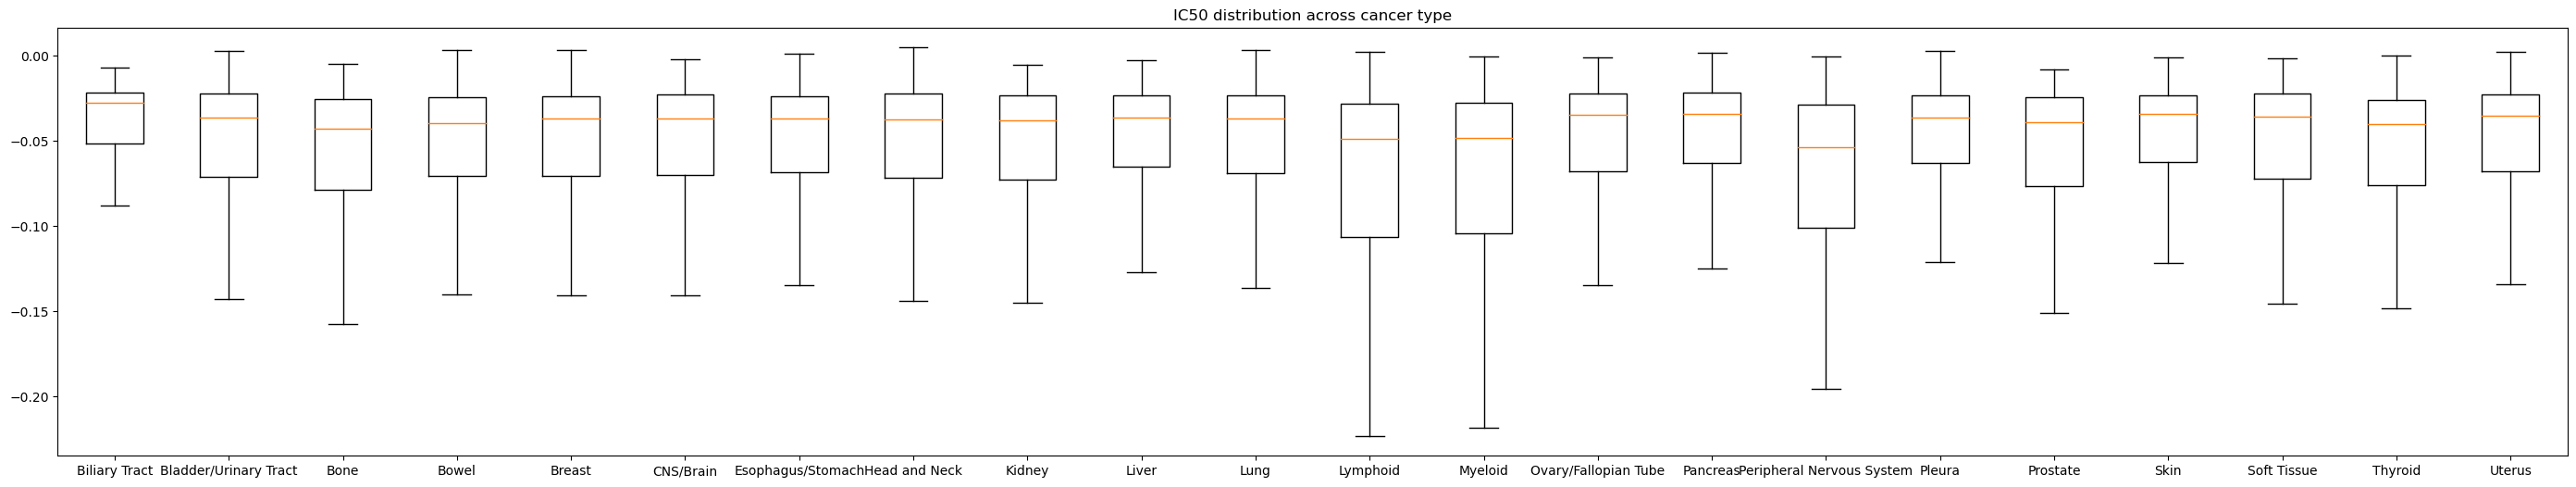

In [41]:
# 암 부위 별로 AUC, IC50 분포 boxplot
plt.figure(figsize=(35, 6))
plt.boxplot(IC50_preds, labels=lineage_names, showfliers=False)
plt.title("IC50 distribution across cancer type")
plt.show()

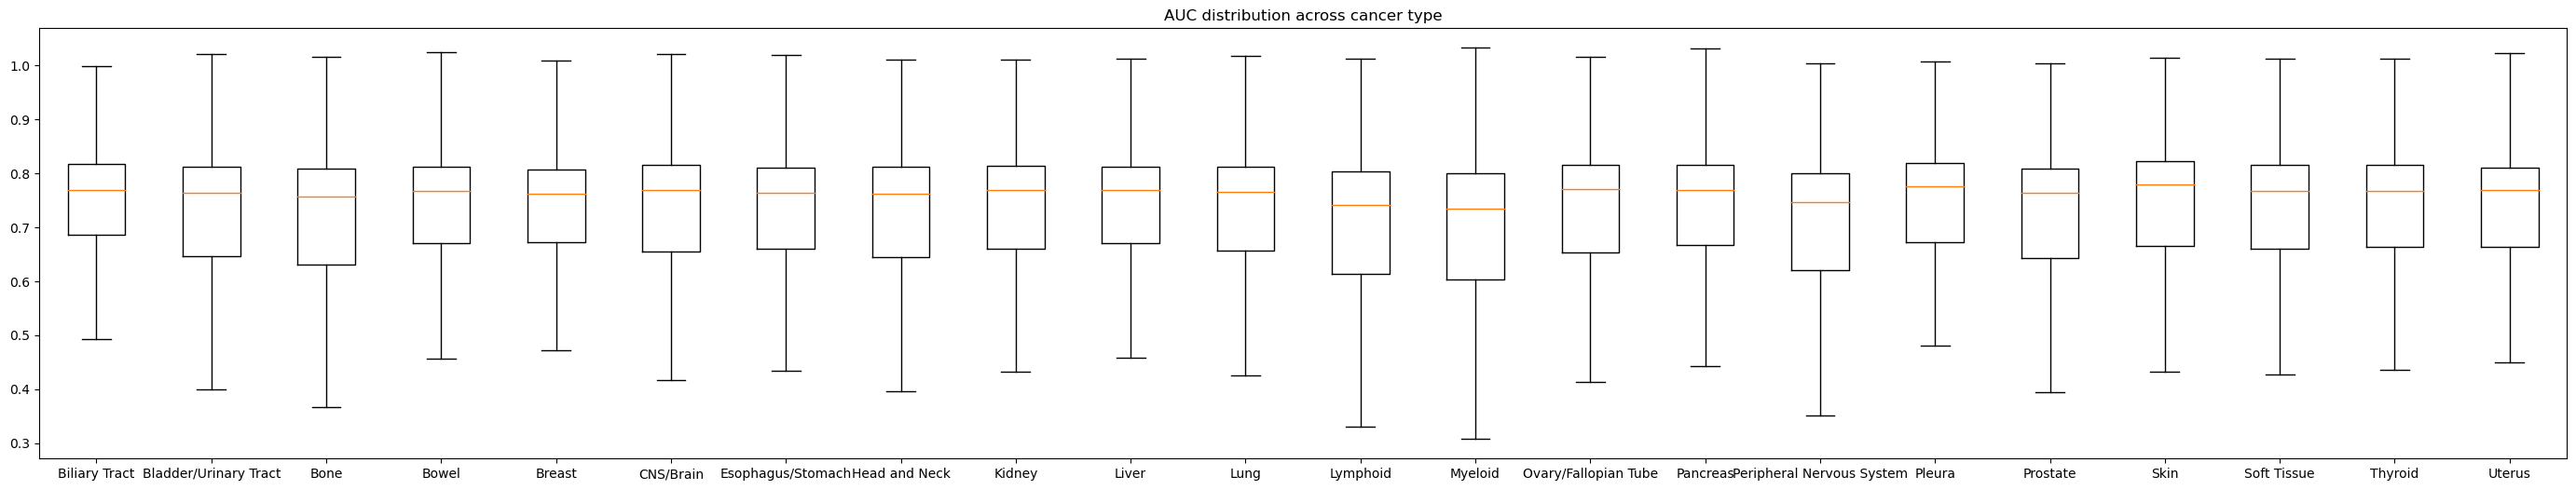

In [36]:
plt.figure(figsize=(35, 6))
plt.boxplot(AUC_preds, labels=lineage_names, showfliers=False)
plt.title("AUC distribution across cancer type")
plt.show()